dataset : https://www.kaggle.com/dansbecker/hot-dog-not-hot-dog/data

loading the dataset uses ImageDataGenerator : https://keras.io/preprocessing/image/

1. Training the algorithm on these files and predicting the labels (1 = not_hot_dog, 0 = hot_dog).
2. Deploying the model (TIP: use heroku) ! The user must have the possibility to upload a photo to test the model.

# 0. Packages

In [1]:
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os

In [2]:
# initial constants

FAST_RUN = False
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

# 1. Loading Data

<AxesSubplot:>

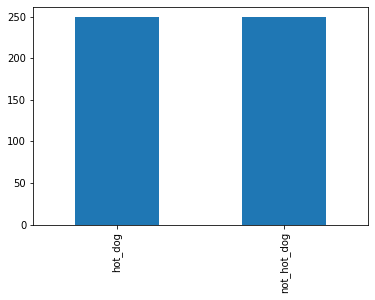

In [15]:
ext_data_path = "/media/seppe/DiskSpaceInvader/hot_dog_or_not"

train_path = os.path.join(ext_data_path, "train")
hot_dogs = os.path.join(train_path, "hot_dog")
not_hot_dogs = os.path.join(train_path, "not_hot_dog")

# test_path = os.path.join(ext_data_path, "test")

hot_dog_filenames = os.listdir(hot_dogs)
not_hot_dog_filenames = os.listdir(not_hot_dogs)

filenames = [f'hot_dog/{i}' for i in hot_dog_filenames] + [f'not_hot_dog/{i}' for i in not_hot_dog_filenames]
categories = ['hot_dog' for i in hot_dog_filenames] + ['not_hot_dog' for i in not_hot_dog_filenames]

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

df.size
df['category'].value_counts().plot.bar()

# 2. Building model



- <b>Input Layer</b>: represents input image data. It will reshape image into single diminsion array. For example, if your image is 64x64 = 4096, it will convert to a (4096,1) array.
- <b>Conv Layer</b>: This layer will extract features from image.
- <b>Pooling Layer</b>: This layer reduces the spatial volume of input image after convolution.
- <b>Fully Connected Layer</b>: Connects the network from a layer to another layer.
- <b>Output Layer</b>: The predicted values layer.

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax')) # 2 because we have cat and dog classes

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization_6 (Batch (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_7 (Batch (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 30, 30, 64)       

# 3. Training the model

In [17]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)
batch_size = 15
print(train_df.info())
print(train_df.head())

total_train = train_df.shape[0]
total_validate = validate_df.shape[0]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  398 non-null    object
 1   category  398 non-null    object
dtypes: object(2)
memory usage: 6.3+ KB
None
                 filename     category
0     hot_dog/1195698.jpg      hot_dog
1      hot_dog/930181.jpg      hot_dog
2  not_hot_dog/124128.jpg  not_hot_dog
3   not_hot_dog/96357.jpg  not_hot_dog
4      hot_dog/910098.jpg      hot_dog


In [18]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    train_path, 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 398 validated image filenames belonging to 2 classes.


In [19]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    train_path, 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)


Found 100 validated image filenames belonging to 2 classes.


In [20]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


earlystop = EarlyStopping(patience=10)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
callbacks = [earlystop, learning_rate_reduction]

In [24]:
epochs = 30
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

Epoch 1/30
26/26 [==============================] - 10s 376ms/step - loss: 0.7593 - accuracy: 0.6214 - val_loss: 2.6732 - val_accuracy: 0.5000
Epoch 2/30
26/26 [==============================] - 10s 381ms/step - loss: 0.7280 - accuracy: 0.6736 - val_loss: 2.7395 - val_accuracy: 0.4778
Epoch 3/30
26/26 [==============================] - ETA: 0s - loss: 0.7459 - accuracy: 0.6580
Epoch 00003: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
26/26 [==============================] - 9s 359ms/step - loss: 0.7459 - accuracy: 0.6580 - val_loss: 2.6410 - val_accuracy: 0.5000
Epoch 4/30
26/26 [==============================] - 9s 360ms/step - loss: 0.7927 - accuracy: 0.6319 - val_loss: 2.3823 - val_accuracy: 0.5222
Epoch 5/30
26/26 [==============================] - 9s 363ms/step - loss: 0.7369 - accuracy: 0.6475 - val_loss: 2.0499 - val_accuracy: 0.5444
Epoch 6/30
26/26 [==============================] - 10s 393ms/step - loss: 0.7591 - accuracy: 0.6162 - val_loss: 2.1521 - val

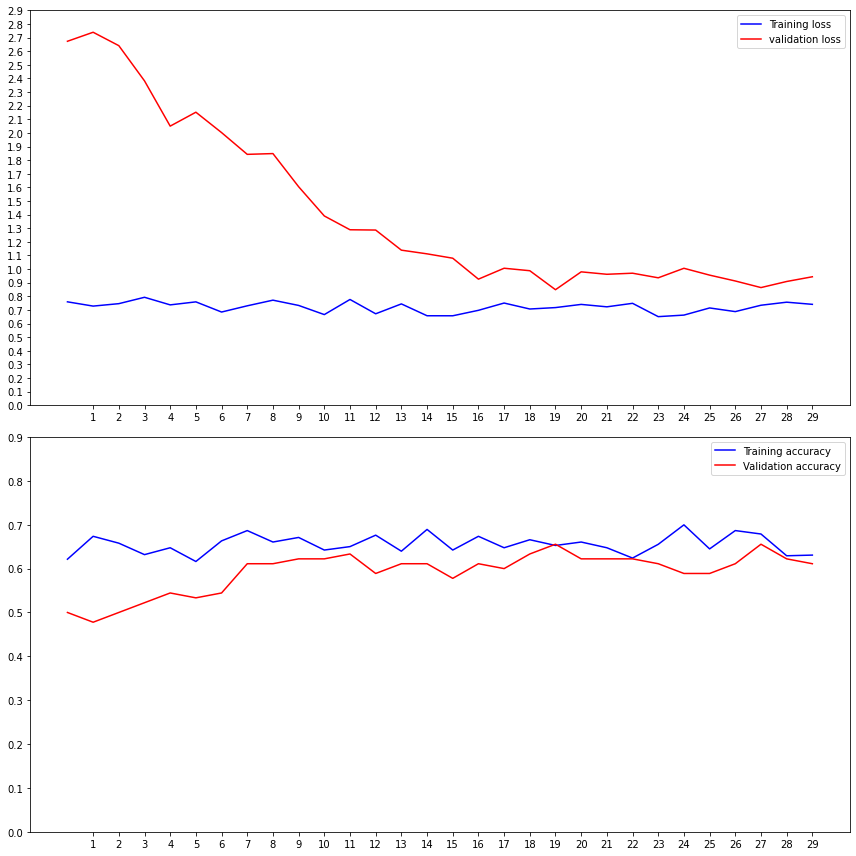

In [31]:
# saving the model

model.save_weights("hot_dog_model.h5")

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 3, 0.1))
ax1.legend()

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))
ax2.set_yticks(np.arange(0, 1, 0.1))
ax2.legend()

plt.tight_layout()
plt.show()